# Fusing Depth Data

## Overview

Most cryptocurrency exchanges do not deliver true tick-by-tick Level-2 data. Instead, they provide conflated feeds in which individual order-book updates are aggregated over short intervals. For example, Binance Futures’ `depth@0ms` stream is still aggregated: You can confirm that its best-bid-offer (BBO) values update less frequently than those in the `bookTicker` stream, which captures every BBO change. Other venues state similar limitations explicitly—Bybit, for instance, publishes the Level 1 data (BBO) every 10ms, the Level 50 data every 20ms, and the Level 200 data every 100ms.

To generate accurate fill simulations and realistic backtesting results, you must therefore fuse multiple depth streams into a single feed that preserves the highest possible update frequency and granularity.

Let’s see Binance Futures as our example.

## Data Preparation

In [1]:
!wget https://datasets.tardis.dev/v1/binance-futures/trades/2025/05/01/BTCUSDT.csv.gz -O BTCUSDT_trades_20250501.csv.gz
!wget https://datasets.tardis.dev/v1/binance-futures/incremental_book_L2/2025/05/01/BTCUSDT.csv.gz -O BTCUSDT_incremental_book_L2_20250501.csv.gz
!wget https://datasets.tardis.dev/v1/binance-futures/book_ticker/2025/05/01/BTCUSDT.csv.gz -O BTCUSDT_book_ticker_20250501.csv.gz

In [2]:
from hftbacktest.data.utils import tardis

tardis.convert(
    [
        'BTCUSDT_trades_20250501.csv.gz',
        'BTCUSDT_incremental_book_L2_20250501.csv.gz'
    ],
    output_filename='BTCUSDT_20250501.npz',
    buffer_size=1_000_000_000,
    snapshot_mode='process'
)

Reading BTCUSDT_trades_20250501.csv.gz
Reading BTCUSDT_incremental_book_L2_20250501.csv.gz
Correcting the latency
Correcting the event order
Saving to BTCUSDT_20250501.npz


array([(3758096386, 1746057600043000000, 1746057600046245000, 94125.2, 1.0000e-02, 0, 0, 0.),
       (3758096387, 1746057600072000000, 1746057601025373000, 93954.8, 0.0000e+00, 0, 0, 0.),
       (3758096388, 1746057600072000000, 1746057601025373000, 94125.1, 1.0798e+01, 0, 0, 0.),
       ...,
       (3758096385, 1746143999978000000, 1746143999980195000, 96406. , 1.5590e+00, 0, 0, 0.),
       (3758096385, 1746143999978000000, 1746143999980195000, 96411.2, 6.1000e-02, 0, 0, 0.),
       (3758096385, 1746143999978000000, 1746143999980195000, 96423.2, 1.0130e+01, 0, 0, 0.)],
      dtype={'names': ['ev', 'exch_ts', 'local_ts', 'px', 'qty', 'order_id', 'ival', 'fval'], 'formats': ['<u8', '<i8', '<i8', '<f8', '<f8', '<u8', '<i8', '<f8'], 'offsets': [0, 8, 16, 24, 32, 40, 48, 56], 'itemsize': 64, 'aligned': True})

Use the backtester to replay the data, get the BBO values from the Level-2 depth feed to compare it with the BBO obtained from the book ticker stream.

In [3]:
import numpy as np
from numba import njit
from hftbacktest import (
    BacktestAsset,
    ROIVectorMarketDepthBacktest
)

@njit
def record_l2_bbo(
    hbt,
    timeout
):
    asset_no = 0
    t = 0
    l2_bbo = np.full((30_000_000, 5), np.nan, np.float64)
    prev_best_bid = np.nan
    prev_best_ask = np.nan
    prev_best_bid_qty = np.nan
    prev_best_ask_qty = np.nan

    # 0: Timeout(no market feed received within the timeout interval)
    # 2: Market Feed
    # Otherwise, an error occurs.
    while hbt.wait_next_feed(False, timeout) in [0, 2]: 
        depth = hbt.depth(asset_no)

        best_bid = depth.best_bid
        best_ask = depth.best_ask
        best_bid_qty = depth.bid_qty_at_tick(depth.best_bid_tick)
        best_ask_qty = depth.ask_qty_at_tick(depth.best_ask_tick)
        
        if (
            best_bid != prev_best_bid 
            or best_ask != prev_best_ask
            or best_bid_qty != prev_best_bid_qty
            or best_ask_qty != prev_best_ask_qty
        ):
            l2_bbo[t, 0] = hbt.current_timestamp
            l2_bbo[t, 1] = prev_best_bid = best_bid
            l2_bbo[t, 2] = prev_best_ask = best_ask
            l2_bbo[t, 3] = prev_best_bid_qty = best_bid_qty
            l2_bbo[t, 4] = prev_best_ask_qty = best_ask_qty
        
            t += 1
        
            if t >= len(l2_bbo):
                raise Exception

    return l2_bbo[:t]

In [4]:
%%time

roi_lb = 50000
roi_ub = 150000

asset = (
    BacktestAsset()
        .data(['BTCUSDT_20250501.npz'])
        .linear_asset(1.0) 
        .constant_order_latency(0, 0)
        .power_prob_queue_model(2)
        .no_partial_fill_exchange()
        .trading_value_fee_model(-0.00005, 0.0007)
        .tick_size(0.1)
        .lot_size(0.001)
        .roi_lb(roi_lb)    
        .roi_ub(roi_ub)
)

hbt = ROIVectorMarketDepthBacktest([asset])

timeout = 100_000_000 # 100ms

l2_bbo = record_l2_bbo(
    hbt,
    timeout
)

_ = hbt.close()

CPU times: user 40.2 s, sys: 2.14 s, total: 42.3 s
Wall time: 42 s


## Comparing BBO updates: Level-2 (depth@0ms) Stream vs bookTicker Stream

The `bookTicker` stream delivers updates more often and leads the Level-2 feed by a small margin.

In [5]:
import polars as pl
from matplotlib import pyplot as plt

In [6]:
df_l2_bbo = pl.DataFrame(l2_bbo)
df_l2_bbo.columns = ['Local Timestamp', 'Bid', 'Ask', 'Bid Qty', 'Ask Qty']

df_l2_bbo = df_l2_bbo.with_columns(
    pl.from_epoch('Local Timestamp', time_unit='ns')
).filter(
    (pl.col('Local Timestamp') > pl.lit('2025-05-01 14:36:03').str.strptime(pl.Datetime, '%Y-%m-%d %H:%M:%S')) &
    (pl.col('Local Timestamp') < pl.lit('2025-05-01 14:36:5').str.strptime(pl.Datetime, '%Y-%m-%d %H:%M:%S'))
)

In [7]:
df_book_ticker = pl.read_csv('BTCUSDT_book_ticker_20250501.csv.gz').with_columns(
    pl.from_epoch('local_timestamp', time_unit='us')
).select(
    'local_timestamp', 'bid_price', 'ask_price', 'bid_amount', 'ask_amount'
).filter(
    (pl.col('local_timestamp') > pl.lit('2025-05-01 14:36:03').str.strptime(pl.Datetime, '%Y-%m-%d %H:%M:%S')) &
    (pl.col('local_timestamp') < pl.lit('2025-05-01 14:36:5').str.strptime(pl.Datetime, '%Y-%m-%d %H:%M:%S'))
)

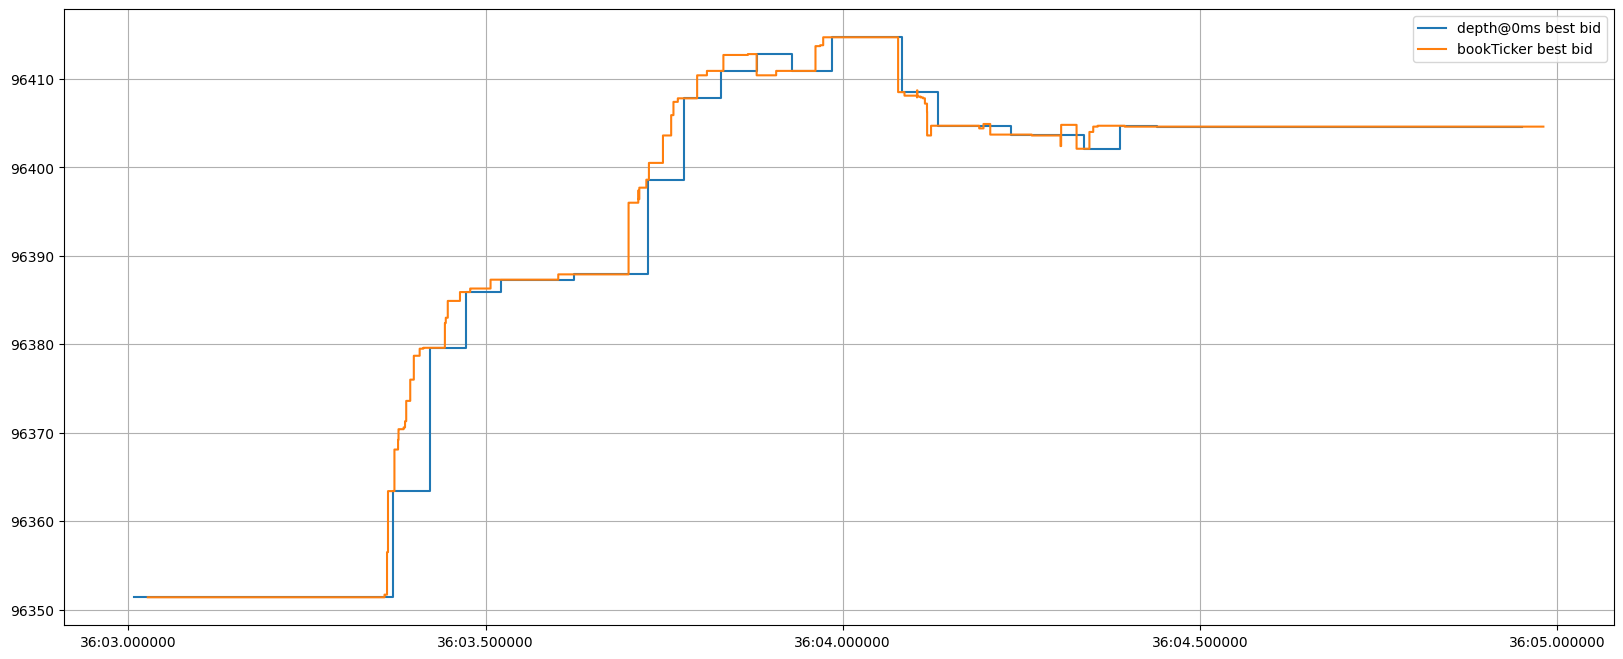

In [8]:
plt.figure(figsize=(20, 8))
plt.step(df_l2_bbo['Local Timestamp'], df_l2_bbo['Bid'], where='post')
plt.step(df_book_ticker['local_timestamp'], df_book_ticker['bid_price'], where='post')
plt.legend(['depth@0ms best bid', 'bookTicker best bid'])
plt.grid()

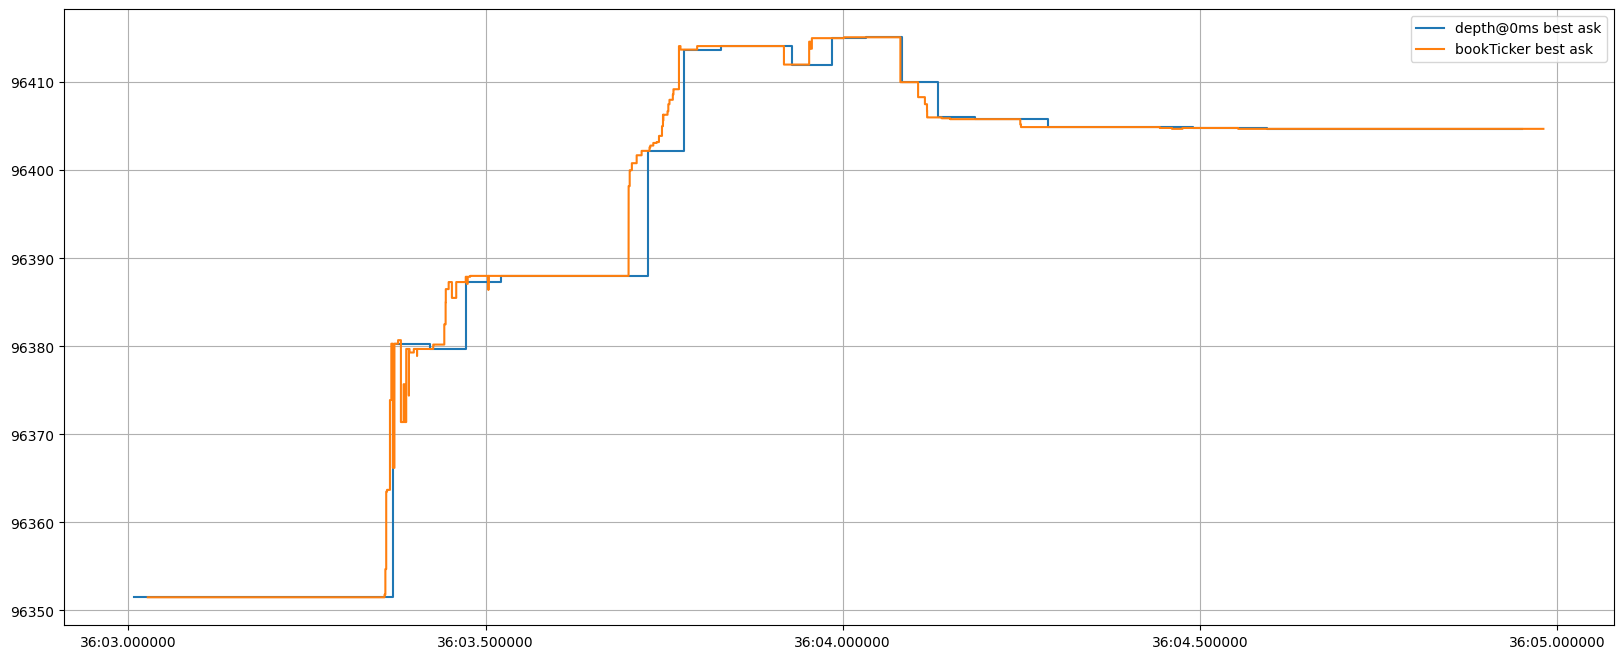

In [9]:
plt.figure(figsize=(20, 8))
plt.step(df_l2_bbo['Local Timestamp'], df_l2_bbo['Ask'], where='post')
plt.step(df_book_ticker['local_timestamp'], df_book_ticker['ask_price'], where='post')
plt.legend(['depth@0ms best ask', 'bookTicker best ask'])
plt.grid()

You’ll notice that the `bookTicker` stream delivers updates far more frequently—especially when you factor in changes to both price and quantity.

In [10]:
with pl.Config(tbl_rows=100):
    print(df_l2_bbo)

shape: (39, 5)
┌───────────────────────────────┬─────────┬─────────┬─────────┬─────────┐
│ Local Timestamp               ┆ Bid     ┆ Ask     ┆ Bid Qty ┆ Ask Qty │
│ ---                           ┆ ---     ┆ ---     ┆ ---     ┆ ---     │
│ datetime[ns]                  ┆ f64     ┆ f64     ┆ f64     ┆ f64     │
╞═══════════════════════════════╪═════════╪═════════╪═════════╪═════════╡
│ 2025-05-01 14:36:03.008176128 ┆ 96351.4 ┆ 96351.5 ┆ 6.344   ┆ 7.159   │
│ 2025-05-01 14:36:03.060811008 ┆ 96351.4 ┆ 96351.5 ┆ 6.368   ┆ 1.297   │
│ 2025-05-01 14:36:03.112276992 ┆ 96351.4 ┆ 96351.5 ┆ 6.528   ┆ 0.128   │
│ 2025-05-01 14:36:03.163234048 ┆ 96351.4 ┆ 96351.5 ┆ 6.878   ┆ 0.188   │
│ 2025-05-01 14:36:03.215074048 ┆ 96351.4 ┆ 96351.5 ┆ 6.584   ┆ 2.819   │
│ 2025-05-01 14:36:03.266274048 ┆ 96351.4 ┆ 96351.5 ┆ 6.399   ┆ 1.996   │
│ 2025-05-01 14:36:03.316154112 ┆ 96351.4 ┆ 96351.5 ┆ 6.399   ┆ 2.127   │
│ 2025-05-01 14:36:03.369733888 ┆ 96363.4 ┆ 96380.3 ┆ 1.12    ┆ 0.006   │
│ 2025-05-01 14:36:03.4

In [11]:
with pl.Config(tbl_rows=100):
    print(df_book_ticker)

shape: (1_432, 5)
┌────────────────────────────┬───────────┬───────────┬────────────┬────────────┐
│ local_timestamp            ┆ bid_price ┆ ask_price ┆ bid_amount ┆ ask_amount │
│ ---                        ┆ ---       ┆ ---       ┆ ---        ┆ ---        │
│ datetime[μs]               ┆ f64       ┆ f64       ┆ f64        ┆ f64        │
╞════════════════════════════╪═══════════╪═══════════╪════════════╪════════════╡
│ 2025-05-01 14:36:03.027063 ┆ 96351.4   ┆ 96351.5   ┆ 6.338      ┆ 7.157      │
│ 2025-05-01 14:36:03.027070 ┆ 96351.4   ┆ 96351.5   ┆ 6.338      ┆ 7.154      │
│ 2025-05-01 14:36:03.027072 ┆ 96351.4   ┆ 96351.5   ┆ 6.338      ┆ 7.121      │
│ 2025-05-01 14:36:03.029315 ┆ 96351.4   ┆ 96351.5   ┆ 6.35       ┆ 7.121      │
│ 2025-05-01 14:36:03.030317 ┆ 96351.4   ┆ 96351.5   ┆ 6.338      ┆ 7.121      │
│ 2025-05-01 14:36:03.045954 ┆ 96351.4   ┆ 96351.5   ┆ 6.338      ┆ 7.119      │
│ 2025-05-01 14:36:03.049547 ┆ 96351.4   ┆ 96351.5   ┆ 6.348      ┆ 7.119      │
│ 2025-05-

## Fusing Multiple Depth Feeds

To obtain the most frequent and fine-grained market depth updates, it is necessary to combine the depth feed with the book ticker feed. The `FuseMarketDepth` utility helps fuse multiple depth update streams into a single order book view.

**Note: Handling Timestamp Inconsistencies**  
When fusing multiple depth feeds, it's possible that an event with a later exchange timestamp may be received before an event with an earlier timestamp from another feed. Accurately reconstructing the order book in such cases would require building a separate order book for each feed and then combining them.

However, this utility builds only a single consolidated order book, where:
- Updates are processed in order of local receipt time.
- The price-level information are updated based on the exchange timestamp.

If an older exchange-timestamped update arrives after a newer one for the same price level, it is discarded. This approach may lead to slight discrepancies between the local order book state and the actual state on the exchange.

**Note: Order Book Inconsistency Between Feeds**  
Each depth feed may present a different snapshot of the order book. When combining them, inconsistencies may arise even if the fused result reflects more up-to-date information.

For example:

- A depth feed may show a best bid/ask (BBO) at 10/11.
- A more current book ticker feed may show BBO at 10/14.

When fused:

The resulting book shows BBO at 10/14.
But price levels above 14 (e.g., 15 and higher) still reflect outdated data from the original depth feed. This results in a partially updated and inconsistent order book. To maintain consistency with the depth feed’s original intent, you would need to build and maintain a separate order book for each feed.

In [12]:
from hftbacktest import event_dtype, TRADE_EVENT, BUY_EVENT, SELL_EVENT
from hftbacktest.data.utils.tardis import convert_depth

def load_book_ticker(file):
    df_book_ticker = pl.read_csv(file)
    ticker_arr = (
        df_book_ticker.with_columns(
            (pl.col('timestamp') * 1000)
                .cast(pl.Int64, strict=True)
                .alias('exch_ts'),
            (pl.col('local_timestamp') * 1000)
                .cast(pl.Int64, strict=True)
                .alias('local_ts'),
            pl.col('ask_price')
                .cast(pl.Float64, strict=True),
            pl.col('ask_amount')
                .cast(pl.Float64, strict=True),
            pl.col('bid_price')
                .cast(pl.Float64, strict=True),
            pl.col('bid_amount')
                .cast(pl.Float64, strict=True),
        )
        .select(['exch_ts', 'local_ts', 'ask_price', 'ask_amount', 'bid_price', 'bid_amount'])
        .to_numpy(structured=True)
    )
    return ticker_arr

def load_depth(file, buffer_size, ss_buffer_size, snapshot_mode):
    df_depth = pl.read_csv(file)
    arr = (
        df_depth.with_columns(
            (pl.col('timestamp') * 1000)
                .cast(pl.Int64, strict=True)
                .alias('exch_ts'),
            (pl.col('local_timestamp') * 1000)
                .cast(pl.Int64, strict=True)
                .alias('local_ts'),
            pl.col('price')
                .cast(pl.Float64, strict=True)
                .alias('px'),
            pl.col('amount')
                .cast(pl.Float64, strict=True)
                .alias('qty'),
            pl.when((pl.col('side') == 'bid') | (pl.col('side') == 'buy'))
                .then(1)
                .when((pl.col('side') == 'ask') | (pl.col('side') == 'sell'))
                .then(-1)
                .otherwise(0)
                .cast(pl.Int8, strict=True)
                .alias('side'),
            pl.when(pl.col('is_snapshot'))
                .then(1)
                .otherwise(0)
                .cast(pl.Int8, strict=True)
                .alias('is_snapshot')
        )
        .select(['exch_ts', 'local_ts', 'px', 'qty', 'side', 'is_snapshot'])
        .to_numpy(structured=True)
    )

    tmp = np.empty(buffer_size, event_dtype)
    ss_bid = np.empty(ss_buffer_size, event_dtype)
    ss_ask = np.empty(ss_buffer_size, event_dtype)
    
    snapshot_mode_flag = 0
    if snapshot_mode == 'ignore':
        snapshot_mode_flag = SNAPSHOT_MODE_IGNORE
    elif snapshot_mode == 'ignore_sod':
        snapshot_mode_flag = SNAPSHOT_MODE_IGNORE_SOD
    row_num = convert_depth(tmp, arr, 0, ss_bid, ss_ask, snapshot_mode_flag)
    
    depth_arr = tmp[:row_num]
    return depth_arr

def load_trades(file):
    df = pl.read_csv(file)
    arr = (
        df.with_columns(
            pl.when(pl.col('side') == 'buy')
                .then(BUY_EVENT | TRADE_EVENT)
                .when(pl.col('side') == 'sell')
                .then(SELL_EVENT | TRADE_EVENT)
                .otherwise(TRADE_EVENT)
                .cast(pl.UInt64, strict=True)
                .alias('ev'),
            (pl.col('timestamp') * 1000)
                .cast(pl.Int64, strict=True)
                .alias('exch_ts'),
            (pl.col('local_timestamp') * 1000)
                .cast(pl.Int64, strict=True)
                .alias('local_ts'),
            pl.col('price')
                .cast(pl.Float64, strict=True)
                .alias('px'),
            pl.col('amount')
                .cast(pl.Float64, strict=True)
                .alias('qty'),
            pl.lit(0)
                .cast(pl.UInt64, strict=True)
                .alias('order_id'),
            pl.lit(0)
                .cast(pl.Int64, strict=True)
                .alias('ival'),
            pl.lit(0.0)
                .cast(pl.Float64, strict=True)
                .alias('fval')
        )
        .select(['ev', 'exch_ts', 'local_ts', 'px', 'qty', 'order_id', 'ival', 'fval'])
        .to_numpy(structured=True)
    )
    return arr

In [13]:
from hftbacktest.data import FuseMarketDepth, correct_local_timestamp, correct_event_order, validate_event_order

def fuse(ticker_arr, depth_arr, trades_arr, tick_size, lot_size, output_filename=None, base_latency=0):
    depth = FuseMarketDepth(tick_size=tick_size, lot_size=lot_size)
    depth.process(ticker_arr, depth_arr)
    
    fused = depth.fused_events()

    buf = np.empty(len(trades_arr) + len(fused), dtype=event_dtype)
    buf[:len(trades_arr)] = trades_arr[:]
    buf[len(trades_arr):] = fused[:]

    print('Correcting the latency')
    tmp = correct_local_timestamp(buf, base_latency=0)
    
    print('Correcting the event order')
    data = correct_event_order(
        tmp,
        np.argsort(tmp['exch_ts'], kind='mergesort'),
        np.argsort(tmp['local_ts'], kind='mergesort')
    )
    
    validate_event_order(data)
    
    if output_filename is not None:
        print('Saving to %s' % output_filename)
        np.savez_compressed(output_filename, data=data)

    return data

In [14]:
ticker_arr = load_book_ticker('BTCUSDT_book_ticker_20250501.csv.gz')
depth_arr = load_depth(
    'BTCUSDT_incremental_book_L2_20250501.csv.gz',
    buffer_size=200_000_000,
    ss_buffer_size=1_000_000,
    snapshot_mode='process'
)
trades_arr = load_trades('BTCUSDT_trades_20250501.csv.gz')

In [15]:
_ = fuse(ticker_arr, depth_arr, trades_arr, tick_size=0.1, lot_size=0.001, output_filename='BTCUSDT_fused_20250501.npz')

Correcting the latency
Correcting the event order
Saving to BTCUSDT_fused_20250501.npz


In [16]:
roi_lb = 50000
roi_ub = 150000

asset = (
    BacktestAsset()
        .data(['BTCUSDT_fused_20250501.npz'])
        .linear_asset(1.0) 
        .constant_order_latency(0, 0)
        .power_prob_queue_model(2)
        .no_partial_fill_exchange()
        .trading_value_fee_model(-0.00005, 0.0007)
        .tick_size(0.1)
        .lot_size(0.001)
        .roi_lb(roi_lb)    
        .roi_ub(roi_ub)
)

hbt = ROIVectorMarketDepthBacktest([asset])

timeout = 100_000_000 # 100ms

l2_bbo_fused = record_l2_bbo(
    hbt,
    timeout
)

_ = hbt.close()

CPU times: user 48 s, sys: 2.32 s, total: 50.3 s
Wall time: 50.3 s


In [17]:
df_l2_bbo_fused = pl.DataFrame(l2_bbo_fused)
df_l2_bbo_fused.columns = ['Local Timestamp', 'Bid', 'Ask', 'Bid Qty', 'Ask Qty']

df_l2_bbo_fused = df_l2_bbo_fused.with_columns(
    pl.from_epoch('Local Timestamp', time_unit='ns')
).filter(
    (pl.col('Local Timestamp') > pl.lit('2025-05-01 14:36:03').str.strptime(pl.Datetime, '%Y-%m-%d %H:%M:%S')) &
    (pl.col('Local Timestamp') < pl.lit('2025-05-01 14:36:5').str.strptime(pl.Datetime, '%Y-%m-%d %H:%M:%S'))
)

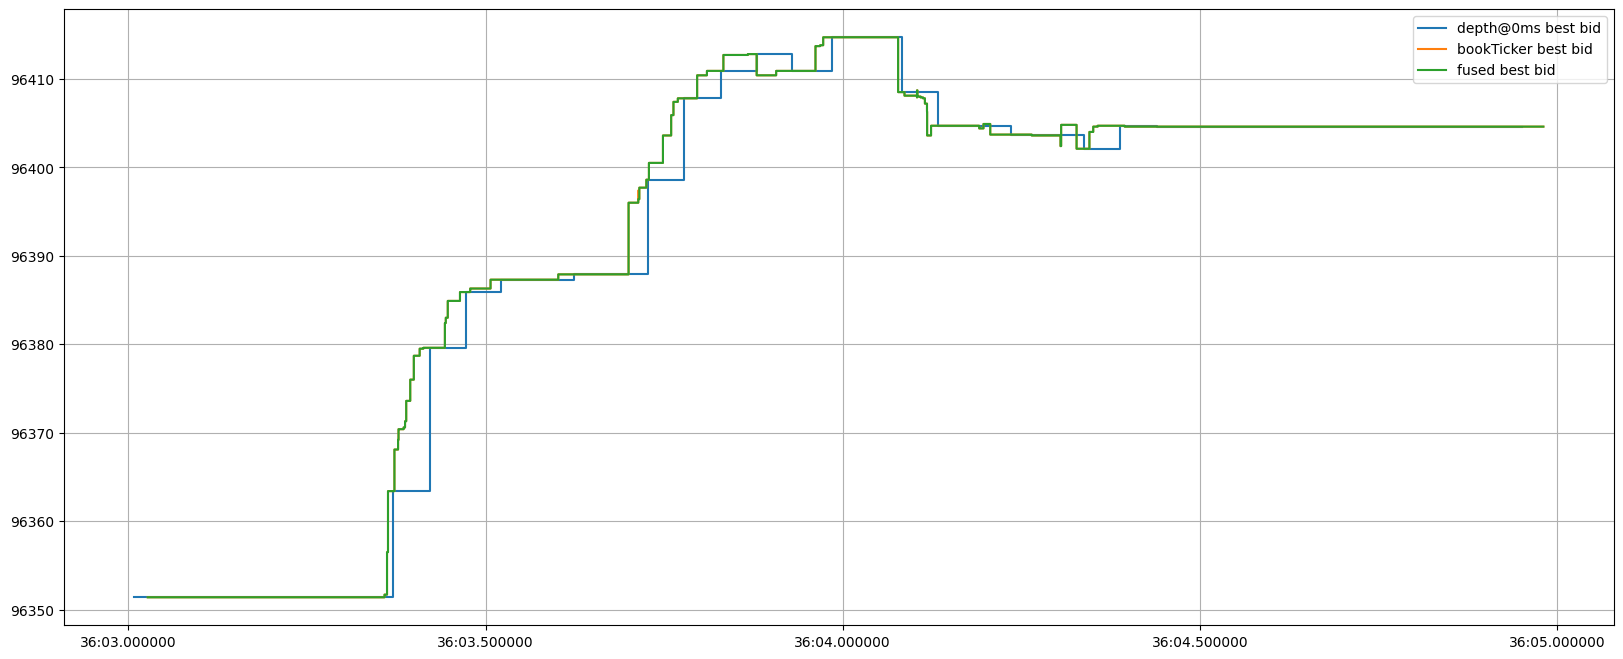

In [18]:
plt.figure(figsize=(20, 8))
plt.step(df_l2_bbo['Local Timestamp'], df_l2_bbo['Bid'], where='post')
plt.step(df_book_ticker['local_timestamp'], df_book_ticker['bid_price'], where='post')
plt.step(df_l2_bbo_fused['Local Timestamp'], df_l2_bbo_fused['Bid'], where='post')
plt.legend(['depth@0ms best bid', 'bookTicker best bid', 'fused best bid'])
plt.grid()

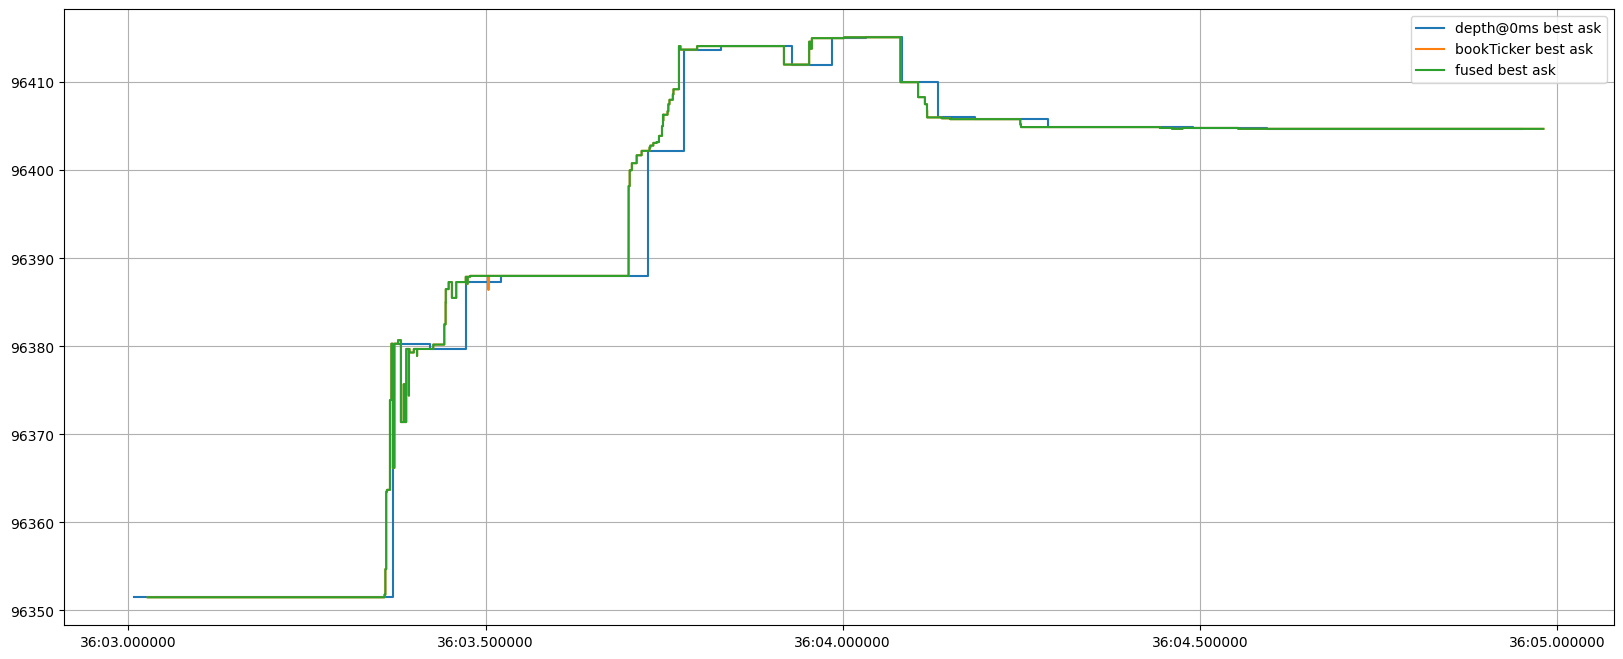

In [19]:
plt.figure(figsize=(20, 8))
plt.step(df_l2_bbo['Local Timestamp'], df_l2_bbo['Ask'], where='post')
plt.step(df_book_ticker['local_timestamp'], df_book_ticker['ask_price'], where='post')
plt.step(df_l2_bbo_fused['Local Timestamp'], df_l2_bbo_fused['Ask'], where='post')
plt.legend(['depth@0ms best ask', 'bookTicker best ask', 'fused best ask'])
plt.grid()

This tutorial will show how this fused data improves backtesting accuracy. (to be continued...)